# **THE EMBEDDED ML-WAND PROJECT**


This project involved developing a machine learning model for gesture recognition based on movement data captured by an IMU (Inertial Measurement Unit). The data, consisting of accelerometer and gyroscope readings, was processed and normalized to feed into a neural network built using TensorFlow. The neural network, consisting of dense layers with dropout and regularization, was trained to classify different gestures, and its architecture was optimized for performance and efficiency. Once trained, the model was converted into a TensorFlow Lite format suitable for deployment on an Arduino board. The final stage involved implementing an Arduino sketch to process real-time IMU data, perform inference using the trained model, and recognize gestures, thereby bridging the gap between machine learning and embedded systems in a real-world application.

[Link to the video](https://youtu.be/CpNBOYuhglQ)

Sources to be considered wihtin this project:

[1] TensorFlow Authors, "TensorFlow Core v2.9.0 Guide," 2023. [Online]. Available: https://www.tensorflow.org/guide.

[2] I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning, MIT Press, 2016. [Online]. Available: http://www.deeplearningbook.org/.

[3] N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting," Journal of Machine Learning Research, vol. 15, pp. 1929-1958, 2014. [Online]. Available: http://jmlr.org/papers/v15/srivastava14a.html.







# Import Libraries and set variables

The script sets up a machine learning project for gesture recognition by importing libraries like TensorFlow and sklearn for modeling and data processing, and matplotlib for visualization. It defines constants for data handling and creates directories for organizing models and plots. The gesture dataset is downloadable from GitHub, gets extracted, ensuring data availability and integrity for model training. This very first setup is essential for the project's subsequent data analysis and model development phases.

In [2]:
import os
import glob
import tensorflow as tf
import tensorflow.keras.models as tfm
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
import tensorflow.keras.utils as tfu
from tensorflow.keras import regularizers
import sklearn.model_selection as skms
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import time
import functools
import IPython.display as ipd
import pandas as pd
import io
import math
import zipfile

SEED = 133
GesSAMPLES = 119
SAMPLERATE = 119
MEASTime = 1 / SAMPLERATE
GYRO_THRESHOLD = 0.02
GRAVITY = 9.81
ACC_THRESHOLD = 0.0

ADDNOISE = True
noiseLVL = 0.1

NUMSPELLS = 5
STROKELEN = GesSAMPLES + 1
LABELS = ["alohomoraCh", "arrestoMCh", "avadaCh", "locoMCh", "revelCh"]

data_set = "gestures"

# create input/output
os.makedirs("models", exist_ok=True)
os.makedirs("plots",  exist_ok=True)
os.makedirs("gestures",  exist_ok=True)
os.makedirs("sets",  exist_ok=True)

!wget https://github.com/th3Flow/mWand/raw/main/python/MovDat.zip

try:
    with zipfile.ZipFile('MovDat.zip', 'r') as zip_ref:
        zip_ref.extractall('gestures')  # Specify your destination folder
    print("Files extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The file is not a zip file or it is corrupted.")
except FileNotFoundError:
    print("Error: The ZIP file does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

!rm -rf MovDat.zip


--2024-01-09 19:35:44--  https://github.com/th3Flow/mWand/raw/main/python/MovDat.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/th3Flow/mWand/main/python/MovDat.zip [following]
--2024-01-09 19:35:44--  https://raw.githubusercontent.com/th3Flow/mWand/main/python/MovDat.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440777 (430K) [application/zip]
Saving to: ‘MovDat.zip’

MovDat.zip          100%[===================>] 430.45K  --.-KB/s    in 0.006s  

2024-01-09 19:35:45 (75.3 MB/s) - ‘MovDat.zip’ saved [440777/440777]

Files extracted successfully.


# Processing the CSV Data

This code segment processes and normalizes data from an IMU (Inertial Measurement Unit) for gesture recognition in machine learning. It involves smoothing accelerometer readings with a low-pass filter, calculating velocities and positions, and correcting gyro drift. The data is then normalized across different metrics (acceleration, gyro, degrees, and distance) for consistency. Optionally, noise can be added to simulate real-world conditions. Finally, the processed data is reshaped and split into training and testing sets, making it ready for use in training a neural network model for gesture classification.

* Read IMU Data: Extracts accelerometer and gyroscope readings from the IMU sensor.

* Apply Low-Pass Filter: Smoothing of the accelerometer data to reduce noise and fluctuations.

* Calculate Velocity and Position: Integrating accelerometer data to derive velocity and then position information.

* Correct Gyro Drift: Adjusting the gyroscope data to account for any drift over time.

* Normalize Data: Scaling of various types of data (acceleration, gyro, degrees, and position) to a consistent range for model input.

* Optional Noise Addition: Random noise is introduced to the data to enhance the robustness of the model against real-world measurement noise.

* Reshape and Store Processed Data: Convert the processed data into a suitable format for machine learning, typically involving reshaping the data into arrays.

* Split Data into Training and Testing Sets: The dataset is divided into training and testing subsets to enable model training and evaluation.

* Prepare Data for Machine Learning Model: Ensures that the data is in the correct format and ready for feeding into a machine learning model for gesture recognition training.

In [3]:
def normalize_distance_data(distance_data):

    # Normalize the distance data
    min_distance = -0.25 #meter
    max_distance = 0.25 #meter
    normalized_data = (distance_data - min_distance) / (max_distance - min_distance)

    return normalized_data

def normalize_gyro_data(gyro_data):

    # Normalize the gyro data
    min_gyro = -2000 #degree/s
    max_gyro = 2000 #degree/s
    normalized_data = (gyro_data - min_gyro) / (max_gyro - min_gyro)

    return normalized_data

def normalize_degree_data(degree_data):

    # Define the known min and max degree values
    min_degree = 0
    max_degree = 360

    # Normalize the degree data
    normalized_data = (degree_data - min_degree) / (max_degree - min_degree)

    return normalized_data

def normalize_accel_data(accel_data):

    min_accel = -4
    max_accel = 4

    # Normalize the acceleration data
    normalized_data = (accel_data - min_accel) / (max_accel - min_accel)

    return normalized_data

def process_imu_data(values, last_values, add_noise=False, noise_level=0.01):
    # Unpack accelerometer and gyroscope data
    ax, ay, az = values[:3]
    gx, gy, gz = values[3:6]
    # print(values[:3], values[3:6])

    # Apply low-pass filter
    ax = low_pass_filter(ax, last_values['ax'], 0.5)
    ay = low_pass_filter(ay, last_values['ay'], 0.5)
    az = low_pass_filter(az, last_values['az'], 0.5)

    # Update last accelerometer values
    last_values.update({'ax': ax, 'ay': ay, 'az': az})

    # Integrate acceleration to get velocity
    vx = ax * GRAVITY * MEASTime
    vy = ay * GRAVITY * MEASTime
    vz = az * GRAVITY * MEASTime

    # Integrate velocity to get position
    x = last_values['x'] + vx * MEASTime
    y = last_values['y'] + vy * MEASTime
    z = last_values['z'] + vz * MEASTime


    # Update position values
    last_values.update({'x': x, 'y': y, 'z': z})

    # Correct the gyro drift
    rollAcc = fast_atan2(ay*GRAVITY, az*GRAVITY) * (180 / math.pi)
    dx = (gx * 0.8) * MEASTime + rollAcc * 0.2

    pitchAcc = fast_atan2(ax*GRAVITY, az*GRAVITY) * (180 / math.pi)
    dy = (gy * 0.8) * MEASTime + pitchAcc * 0.2

    # Apply threshold to gyro z-axis data
    dz = 0 if abs(gz) < GYRO_THRESHOLD else gz * MEASTime

    #NORMALIZATION
    x = normalize_distance_data(x)
    y = normalize_distance_data(y)
    z = normalize_distance_data(z)

    #NORMALIZATION
    ax = normalize_accel_data(ax)
    ay = normalize_accel_data(ay)
    az = normalize_accel_data(az)

    #NORMALIZATION
    dx = normalize_degree_data(dx)
    dy = normalize_degree_data(dy)
    dz = normalize_degree_data(dz)

    #NORMALIZATION
    gx = normalize_gyro_data(gx)
    gy = normalize_gyro_data(gy)
    gz = normalize_gyro_data(gz)

    # Return the processed data
    return [ax, ay, az, dx, dy, dz, x, y, z]

def low_pass_filter(current_val, previous_val, alpha):

    if abs(current_val) < ACC_THRESHOLD:
        current_val = 0
    return alpha * current_val + (1 - alpha) * previous_val

def add_noise_to_imu_data(imu_data, noise_level=0.01):

    noise = np.random.normal(0, noise_level, imu_data.shape)
    imu_data_noisy = imu_data + noise

    return imu_data_noisy

def fast_atan2(y, x):
    n1 = 0.97239411
    n2 = -0.19194795
    if x != 0.0:
        atan = (math.pi / 4.0) * y / x
        z = atan * atan
        result = atan * ((n1 + n2 * z) / (1.0 + (n1 + n2) * z))
        if x < 0.0:
            return result - math.pi if y < 0.0 else result + math.pi
    return math.pi / 2.0 if y > 0.0 else -math.pi / 2.0 if y < 0.0 else 0

def load_dataset(directory, one_hot=True, seed=SEED, addNOISE=True, noiselvl = noiseLVL):
    arrays = []  # Ensure this remains a list
    labels = []
    label_map = {os.path.basename(filename).split('.')[0]: i for i, filename in enumerate(sorted(glob.glob(f"{directory}/*.csv")))}

    for file_name in sorted(glob.glob(f"{directory}/*.csv")):
        gesture_label = label_map[os.path.basename(file_name).split('.')[0]]
        with open(file_name, 'r') as file:
            lines = file.readlines()

        lines = lines[1:]  # Skip header
        measurement = []
        measurement_count = 0
        last_values = {'ax': 0, 'ay': 0, 'az': 0, 'x': 0, 'y': 0, 'z': 0}

        for line in lines:
            if line.strip():  # If the line is not empty
                values = [float(x) for x in line.strip().split(',')]
                processed_data = process_imu_data(values, last_values)

                measurement.append(processed_data)
                # print(processed_data)
            else:
                if measurement:  # If there is a measurement, process it

                    if addNOISE:
                        measurement = add_noise_to_imu_data(np.array(measurement), noiselvl)


                    measurement_array = np.array(measurement).reshape(-1)
                    arrays.append(measurement_array)  # Append to the list
                    labels.append(gesture_label)
                    measurement = []  # Reset for the next measurement
                    measurement_count += 1
                    last_values = {'ax': 0, 'ay': 0, 'az': 0, 'x': 0, 'y': 0, 'z': 0}

        if measurement:  # Process the last measurement if it exists

            if addNOISE:
                        measurement = add_noise_to_imu_data(np.array(measurement), noiselvl)


            measurement_array = np.array(measurement).reshape(-1)
            arrays.append(measurement_array)  # Append to the list
            labels.append(gesture_label)

        print(f"Processing {file_name}: {measurement_count} measurements found.")

    arrays = np.array(arrays)  # Convert the list to a NumPy array here
    labels = np.array(labels)

    if one_hot:
        labels = tfu.to_categorical(labels, num_classes=NUMSPELLS)

    X_train, X_test, y_train, y_test = skms.train_test_split(arrays, labels, test_size=0.4, random_state=seed)
    return X_train, X_test, y_train, y_test

# Load the Data Set and generate Train and Test Data

In [4]:
X_train, X_test, y_train, y_test = load_dataset(data_set, SEED, 1, ADDNOISE, noiseLVL)
np.save('sets/X_train.npy', X_train)
np.save('sets/X_test.npy', X_test)
np.save('sets/y_train.npy', y_train)
np.save('sets/y_test.npy', y_test)

Processing gestures/alohomoraCh.csv: 45 measurements found.
Processing gestures/arrestoMCh.csv: 44 measurements found.
Processing gestures/avadaCh.csv: 46 measurements found.
Processing gestures/locoMCh.csv: 45 measurements found.
Processing gestures/revelCh.csv: 44 measurements found.


# Setting the structure of the Neural Network

* Activation Function: A LeakyReLU activation function with a 0.1 negative slope is employed. This function helps to address the issue of "dying neurons" in the network.
"Dying neurons" in neural networks using ReLU activation functions occur when neurons stop learning and only output zeros, becoming inactive due to consistently negative input weights leading to zero gradients during backpropagation.

* Model Architecture: The model is a sequential stack of layers, specifically designed to prevent overfitting and enhance learning.

The "sandglass" structure of the model, characterized by a particular pattern of layer units (71-28-71), suggests a focus on feature extraction and re-expansion. This architecture initially compresses or condenses the input data (narrowing down to 28 units), which can help in extracting essential features. Subsequently, it re-expands these features (back to 71 units), potentially allowing the network to reconstruct or refine these features before making a final classification with the output layer. This design can be effective in capturing complex patterns in data while maintaining a balance between model complexity and generalization.

In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

hidden_activation = tf.keras.layers.LeakyReLU(0.1)
dropoutOne = 0.4
dropoutTwo = 0.2
dropoutThree = 0
l2_reg = 0.001  # L2 regularization factor

model = tfm.Sequential([
    tfl.Dense(units=71, activation=hidden_activation, kernel_regularizer=regularizers.l2(l2_reg)),
    tfl.Dropout(dropoutOne),
    tfl.Dense(units=28, activation=hidden_activation, kernel_regularizer=regularizers.l2(l2_reg)),
    tfl.Dropout(dropoutTwo),
    tfl.Dense(units=71, activation=hidden_activation, kernel_regularizer=regularizers.l2(l2_reg)),
    tfl.Dropout(dropoutThree),
    tfl.Dense(units=NUMSPELLS, activation="softmax")
])

model_name = "FMWandModel"

X_train shape: (134, 1071)
y_train shape: (134, 5)


# Optimize and train the weights

The code initiates by setting a consistent random seed for reproducibility across various libraries. It then constructs the model with the defined architecture tailored to the shape of X_train and retrieves its initial weights. A key feature of the training process is the use of an exponential decay learning rate schedule applied to the Adam optimizer, which gradually decreases the learning rate during training. This helps in fine-tuning the model's learning process, potentially leading to better performance and stability. The model is then compiled with categorical cross-entropy as the loss function and accuracy as the metric. For training, the model undergoes 100 epochs with early stopping employed to prevent overfitting, monitoring validation accuracy with a patience of 10 epochs. The model trains on mini-batches of size 8 and uses 40% of the training data for validation. The total number of epochs run, potentially less than 100 due to early stopping, is recorded in the results dictionary for later analysis.

In [6]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

results = {}

# get weights for the given seed
model.build(X_train.shape)
weights = model.get_weights()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.4, batch_size=8, verbose=1, callbacks=[tfc.EarlyStopping(monitor="val_accuracy", patience=10, mode="max", restore_best_weights=False)]).history
epochs = len(history["loss"])
results["Epochs"] = epochs

Epoch 1/100
10/10 [==============================] - 5s 84ms/step - loss: 1.8334 - accuracy: 0.2875 - val_loss: 1.8169 - val_accuracy: 0.2778
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 1.7640 - accuracy: 0.3000 - val_loss: 1.7657 - val_accuracy: 0.3333
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 1.7326 - accuracy: 0.3000 - val_loss: 1.6798 - val_accuracy: 0.5926
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 1.6888 - accuracy: 0.3250 - val_loss: 1.6810 - val_accuracy: 0.3333
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 1.5474 - accuracy: 0.4500 - val_loss: 1.4644 - val_accuracy: 0.7593
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 1.5870 - accuracy: 0.3875 - val_loss: 1.3584 - val_accuracy: 0.7963
Epoch 7/100
10/10 [==============================] - 0s 17ms/step - loss: 1.3620 - accuracy: 0.5750 - val_loss: 1.3093 - val_accuracy: 0.6667
Epoch 

# Test the full training Model and compare to GPU


In this code, the neural network model's weights are reset to their initial state, ensuring a consistent starting point for training. An exponential decay learning rate schedule is set up for the Adam optimizer, beginning at 0.001 and reducing gradually, to optimize the learning process. The model is then compiled with this optimizer, using categorical cross-entropy for loss and accuracy for evaluation. Training is executed on the entire dataset without a validation split, with the total training time measured and recorded. This approach focuses on maximizing data utilization for training and efficiently tracking training duration, especially relevant for GPU-based training environments.

In [7]:
model.set_weights(weights)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
train_start = time.time()
model.fit(X_train, y_train, epochs=epochs, validation_split=0.0, batch_size=8, verbose=1)
results["Training time GPU"] = f"{(time.time() - train_start):.2f} s"

Epoch 1/24
17/17 [==============================] - 3s 6ms/step - loss: 1.8127 - accuracy: 0.2612
Epoch 2/24
17/17 [==============================] - 0s 6ms/step - loss: 1.8089 - accuracy: 0.2463
Epoch 3/24
17/17 [==============================] - 0s 8ms/step - loss: 1.6515 - accuracy: 0.3433
Epoch 4/24
17/17 [==============================] - 0s 9ms/step - loss: 1.5121 - accuracy: 0.4851
Epoch 5/24
17/17 [==============================] - 0s 11ms/step - loss: 1.3169 - accuracy: 0.5746
Epoch 6/24
17/17 [==============================] - 0s 13ms/step - loss: 1.1023 - accuracy: 0.7537
Epoch 7/24
17/17 [==============================] - 0s 12ms/step - loss: 0.9408 - accuracy: 0.7463
Epoch 8/24
17/17 [==============================] - 0s 10ms/step - loss: 0.8904 - accuracy: 0.7239
Epoch 9/24
17/17 [==============================] - 0s 12ms/step - loss: 0.7201 - accuracy: 0.8433
Epoch 10/24
17/17 [==============================] - 0s 9ms/step - loss: 0.6338 - accuracy: 0.8433
Epoch 11/24
17

# Convert calculated Model to TensorFlowLite

This code should efficiently convert a TensorFlow Keras model into TensorFlow Lite (TFLite) format, offering both standard and optimized versions. The conversion employs TFLiteConverter, adapting the model for lightweight deployment. The optimized version incorporates quantization and INT8 operations, significantly reducing the model size and potentially boosting inference speed, crucial for resource-constrained environments like mobile or embedded systems. The process includes generating a representative dataset for quantization accuracy. Post-conversion, the models are saved, and their sizes are reported, highlighting the effectiveness of optimization in shrinking the model footprint while maintaining functionality, a key benefit for deployment in limited-resource scenarios.

In [8]:
def convert_to_tflite(model, X_train, output_path, optimized=False):
    # Setting up the converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply optimization if needed
    if optimized:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        # Ensure representative_dataset is a callable that returns a generator
        converter.representative_dataset = lambda: representative_dataset_generator(X_train)

    # Convert the model
    tflite_model = converter.convert()

    # Save the converted model
    model_filename = output_path + ("_opt" if optimized else "") + ".tflite"
    with open(model_filename, "wb") as f:
        f.write(tflite_model)

    return model_filename, tflite_model

def representative_dataset_generator(X_train):
    for value in X_train:
        # Prepare each sample as expected by the model (e.g., reshaping, scaling)
        processed_value = np.expand_dims(value, 0).astype(np.float32)
        # print("Yielding sample:", processed_value.shape)
        yield [processed_value]

# Paths for the model files
output_path = "models/model"
model_name = "mWand Model"

# Convert and save the models
model_path, tfModel  = convert_to_tflite(model, X_train, output_path, optimized=False)
optimized_model_path, tfModel_opt = convert_to_tflite(model, X_train, output_path, optimized=True)

# Print the sizes of the models
print(f"Size of the standard model: {os.path.getsize(model_path)} bytes")
print(f"Size of the optimized model: {os.path.getsize(optimized_model_path)} bytes")

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Size of the standard model: 325112 bytes
Size of the optimized model: 84616 bytes


# Evaluate the Performance of the Model

A comprehensive evaluation of both a TensorFlow model and its optimized TensorFlow Lite (TFLite) counterpart. The evaluate_model function first assesses the standard model's accuracy on test data, comparing predicted and actual labels. It then evaluates the optimized TFLite model, handling quantized inputs and outputs to accurately gauge its performance. The process generates accuracies for both models, providing a clear comparison of their effectiveness. This evaluation is particularly useful in balancing the trade-offs between model size and accuracy, a critical consideration in resource-constrained deployment environments like edge computing or mobile devices. By executing and printing these results, the code aids in decision-making for deploying the most efficient model without compromising on performance.

In [9]:
def evaluate_model(model, X_test, y_test, optimized_model_path):
    results = {}

    # Evaluate the full model
    predictions_full = model.predict(X_test, verbose=0)
    predictions_full = np.argmax(predictions_full, axis=1)
    results["Full model accuracy"] = f"{(np.sum(predictions_full == y_test.argmax(axis=1)) / y_test.shape[0] * 100):.2f} %"

    # Load and evaluate the optimized model
    interpreter = tf.lite.Interpreter(model_path=optimized_model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_scale, input_zero_point = interpreter.get_input_details()[0]["quantization"]
    output_scale, output_zero_point = interpreter.get_output_details()[0]["quantization"]

    predictions_opt = np.zeros((y_test.shape[0]))
    for i, sample in enumerate(X_test):
        sample_quantized = np.expand_dims(sample / input_scale + input_zero_point, 0).astype(np.int8)
        interpreter.set_tensor(input_index, sample_quantized)
        interpreter.invoke()
        predictions_opt[i] = np.argmax(interpreter.get_tensor(output_index)[0])

    results["Optimized model accuracy"] = f"{(np.sum(predictions_opt == y_test.argmax(axis=1)) / y_test.shape[0] * 100):.2f} %"

    return results, predictions_full, predictions_opt, input_scale, input_zero_point, output_scale, output_zero_point

In [10]:
# Evaluate the models
results, predictions_full, predictions_opt, input_scale, input_zero_point, output_scale, output_zero_point = evaluate_model(model, X_test, y_test, optimized_model_path)

# Print the results
print(results)

{'Full model accuracy': '96.67 %', 'Optimized model accuracy': '96.67 %'}


# Generate and plot the confusion Matrix

Specialized tool for visualizing the performance of an optimized machine learning model, specifically focusing on classification accuracy. It works by first ensuring compatibility with one-hot encoded labels, converting them to class labels if necessary. The core of the function involves generating a confusion matrix that contrasts the model's predictions against actual labels, providing a clear, quantified view of its performance. This matrix is then visualized in an easily interpretable format, using a blue color scheme for clarity. The resulting plot, saved as a high-resolution image, serves as a valuable tool for analyzing the model's strengths and weaknesses in classification tasks, thereby aiding in refining and enhancing the model's accuracy.

<Figure size 5000x1200 with 0 Axes>

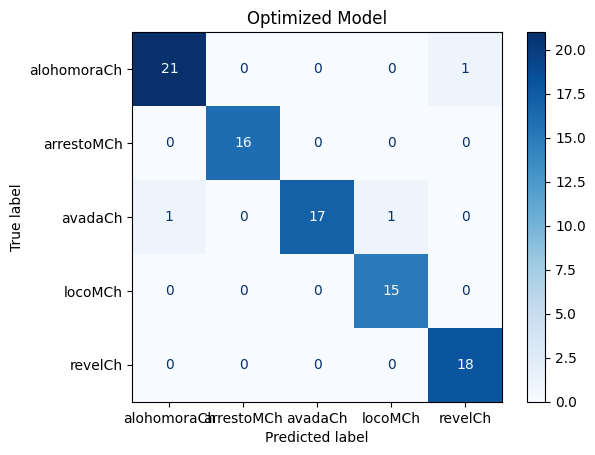

In [11]:
# Assuming LABELS, predictions_full, and predictions_opt are defined as before

def plot_confusion_matrix_optimized(y_test, predictions_opt, LABELS):
    # Convert one-hot encoded y_test to class labels if necessary
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    # Plot the confusion matrix of the optimized model
    confusion_matrix = tf.math.confusion_matrix(y_test_labels, predictions_opt).numpy()
    display = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)

    # Plotting
    plt.figure(figsize=(50, 12))
    display.plot(cmap="Blues")
    plt.title("Optimized Model")
    plt.savefig("plots/optimized_model_confusion_matrix.png", dpi=600)
    plt.show()

# Call the function with your data
plot_confusion_matrix_optimized(y_test, predictions_opt, LABELS)


The confusion matrix indicates high accuracy for a five-class optimized model, with most predictions correctly falling on the diagonal. Minor misclassifications are rare, showing the model's robust performance in classifying gestures.

The displayed confusion matrix for an optimized model demonstrates excellent predictive performance for gesture recognition, with the majority of gestures such as "Alohomora" and "Revelio" being accurately identified. There is a slight confusion between "Alohomora" and "Locomotor," indicating a small area for improvement. Overall, the model shows strong classification capabilities with minimal errors, here.

# Create the Header Files for the Hardware

Here we integrate a TensorFlow Lite model with an Arduino-based system. It begins by loading the optimized TensorFlow Lite model from a file, converting its binary data into a C array format. This array is then saved into a header file (model.h), enabling its use in an Arduino environment. Additionally, the snippet creates a second header file (model_params.h) containing essential model parameters like input and output scales and zero points. These parameters are critical for accurate data processing and interpretation in the Arduino context. The inclusion of header guards in model_params.h ensures safe and repeated use across different parts of a C/C++ project. This approach effectively bridges the gap between sophisticated machine learning models and the more constrained environment of microcontrollers, exemplifying how advanced AI techniques can be deployed in embedded systems.

The *model_params.h* file in an Arduino project contains critical parameters for a TensorFlow Lite model, specifically focusing on quantization aspects necessary for microcontroller environments. It includes the input scale (input_scale) and zero point (input_zero_point), which are essential for adjusting real-world input data to the model's expected format. Similarly, it stores the output scale (output_scale) and zero point (output_zero_point), crucial for correctly interpreting the model's quantized output. These parameters ensure the data is accurately processed, matching the model's training and quantization specifications for reliable performance in embedded systems.

In [12]:
# Load the TensorFlow Lite model file
tflite_model_file = optimized_model_path
with open(tflite_model_file, 'rb') as file:
    tflite_model = file.read()

# Convert the model to a C array
c_array = ','.join(map(lambda x: str(x), tflite_model))
c_array = f"unsigned char model[] = {{{c_array}}};"

# Save the C array to a header file
with open('model.h', 'w') as file:
    file.write(c_array)

with open('model_params.h', 'w') as file:
    file.write(f"#ifndef MODEL_PARAMS_H\n#define MODEL_PARAMS_H\n\n")
    file.write(f"const float input_scale = {input_scale};\n")
    file.write(f"const int input_zero_point = {input_zero_point};\n")
    file.write(f"const float output_scale = {output_scale};\n")
    file.write(f"const int output_zero_point = {output_zero_point};\n\n")
    file.write(f"#endif // MODEL_PARAMS_H\n")